In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import OrthogonalMatchingPursuit
import copy
from collections import Counter

<h2>Game modeling</h2>

In [3]:
def stringify(seq):
    string = ''
    for n in seq:
        string+=str(n)
    return string

In [60]:
n = 12
sequence_list = np.array([np.array(list(bin(i)[3:]),dtype=np.int32) for i in range(2**n, 2**(n+1))])
len(sequence_list)

4096

In [61]:
#Hidden Rules
rule1 = [0,0,1,1]
rule2 = [1,1,0,1]
reward1 = 5
reward2 = 10
def estimate_cost(sequence):
    reward = 0
    for k in range(n-3):
        if np.all(sequence[k:k+4]==rule1):
            reward += reward1
        elif np.all(sequence[k:k+4]==rule2):
            reward += reward2
    return reward

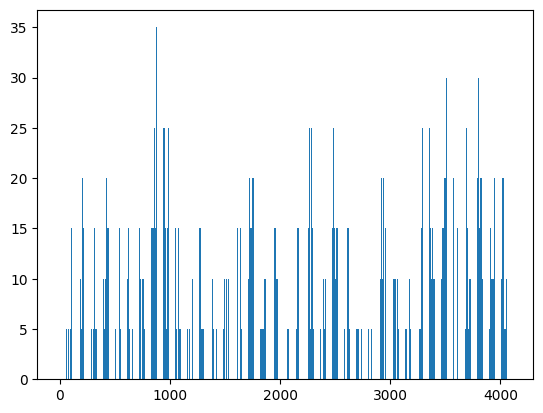

877
[0 0 1 1 0 1 1 0 1 1 0 1]
35


In [205]:
sequence_cost = []
for sequence in sequence_list:
    sequence_cost.append(estimate_cost(sequence))
sequence_cost = np.array(sequence_cost)

plt.bar([i for i in np.arange(len(sequence_list))],sequence_cost,width=0.5)
plt.show()
ma = np.argmax(sequence_cost)
print(ma)
print(sequence_list[ma])
print(sequence_cost[ma])

<h2>Compressive Sensing</h2>
<h3>Ideal compressive sensing</h3>

In [54]:
def bin_to_pattern(x):
    return [ [1-int(i), int(i)] for i in x ]

In [55]:
def create_specific_patterns(mode1,mode2,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(size-mode1-(mode2-mode1-1)-2) )
    return pats

In [56]:
def create_specific_patterns3(mode1,mode2,mode3,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            for k in range(2):
                pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(mode3-(mode2-mode1-1)-mode1-2) + bin_to_pattern(str(k)) + [[1,1]]*(size -mode1-(mode2-mode1-1)-(mode3-(mode2-mode1-1)-mode1-2)-3) )
    return pats

In [57]:
def create_specific_patterns4(mode1,mode2,mode3,mode4,size):
    pats = []
    temp_pats = create_specific_patterns3(mode1,mode2,mode3,size)
    for p in temp_pats:
        for k in range(2):
            p_prime = copy.deepcopy(p)
            p_prime[mode4] = bin_to_pattern(str(k))[0]
            pats.append(p_prime)
    return pats

In [58]:
def dev_pattern(pat):
    f = np.array([1])
    for i in pat:
        f = np.kron(i,f)
    return f

1592.0468760355432
877
[0 0 1 1 0 1 1 0 1 1 0 1]
1592.0468760355432


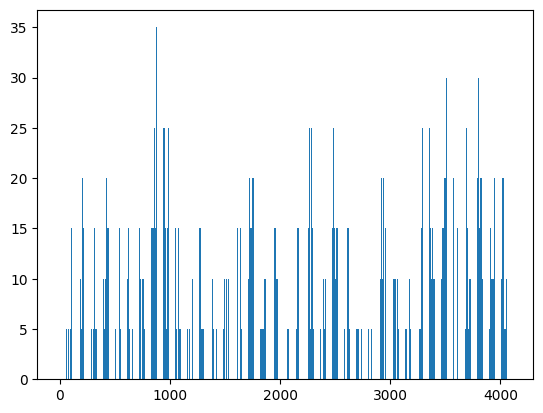

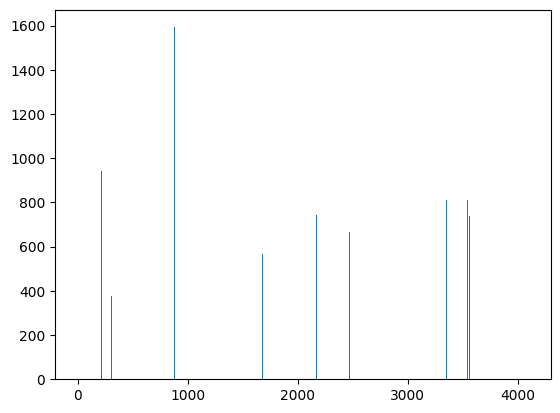

In [206]:
#Quadruplets measurements
all_pat = []
y = []

all_pat = []
# for i in range(n):
#     for j in range(i+1,n):
#         for k in range(j+1,n):
#             for l in range(k+1,n):
#                 all_pat += create_specific_patterns4(i,j,k,l,n)
for i in range(n-3):
    all_pat += create_specific_patterns4(i,i+1,i+2,i+3,n)

# print(len(all_pat))

Phi = np.array([dev_pattern(p) for p in all_pat])
y = np.array(Phi * np.matrix(sequence_cost).T).T[0]

omp = OrthogonalMatchingPursuit(n_nonzero_coefs=20)
omp.fit(Phi, y)
coefficients = [ i if i>0 else 0 for i in omp.coef_]

print(coefficients[877])
ma = np.argmax(coefficients)
print(ma)
print(sequence_list[ma])
print(coefficients[ma])

plt.bar([i for i in np.arange(len(sequence_list))],sequence_cost,width=0.5)
plt.show()
plt.bar([i for i in np.arange(len(coefficients))],coefficients,width=5)
plt.show()
y_ideal = y

<h3>Estimated measurement monte carlo</h3>

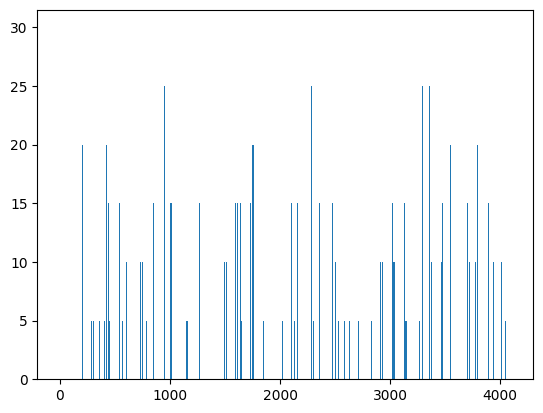

In [ ]:
#Sample from possible sequences (be careful not to take the solution already)
sample_index = np.random.randint(0,len(sequence_list),1200)
print(877 in sample_index)

seq_sample = sequence_list[sample_index]
seq_sample_cost = sequence_cost[sample_index]

sequence_cost_spectrum = np.zeros_like(sequence_cost)
sequence_cost_spectrum[sample_index] = sequence_cost[sample_index]
plt.bar(range(len(sequence_cost)), sequence_cost_spectrum)
plt.show()

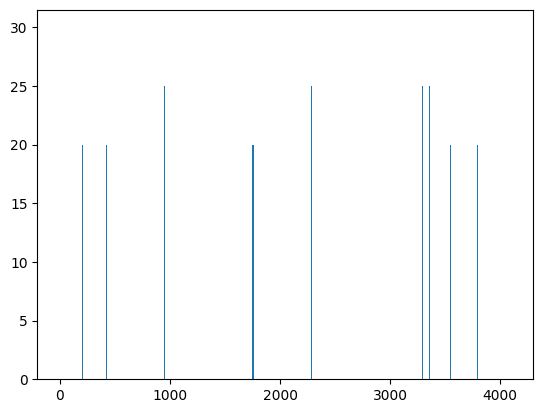

In [287]:
sequence_cost_spectrum[sequence_cost_spectrum<20]=0
plt.bar(range(len(sequence_cost)), sequence_cost_spectrum)
plt.show()

In [288]:
all_pat = []
y = []


all_pat = []
for i in range(n-3):
    all_pat += create_specific_patterns4(i,i+1,i+2,i+3,n)

Phi = np.array([dev_pattern(p) for p in all_pat])
y = np.array(Phi * np.matrix(sequence_cost_spectrum).T).T[0]

y = np.array(y)
y

array([ 40,  60,  75, 120,  20, 275, 175, 100,  60,  80, 165, 830, 125,
       265, 175,  20,   0, 100,  80,  60,   0, 240, 590, 360,  20, 125,
        90, 450, 105, 245,  60,  60,   0,  20, 165,  60,   0, 170, 310,
       200,  20,  85,  60, 425, 225, 425, 310, 110,   0,  20,  65,  40,
         0, 225, 380, 105,  40, 185,  85, 510, 160, 460, 155, 155,  20,
        20, 120,  85,   0, 150, 305, 245,  25, 135,  60, 625,  90, 445,
       180,  80,   0,  45,  25, 130,   0, 180, 390, 320,   0,  90,  60,
       535,  75, 410, 210, 115,   0,   0,  75,  60,   0,  85, 450, 215,
        25,  50,  85, 505, 160, 440, 355,  80,   0,  25,  50,   0,   0,
       160, 395, 170,  90,  70,  40, 485, 360, 445, 195, 100,  45,  45,
        70,  25,  45,  45, 265, 220, 215, 145,  60, 545, 385, 205, 165,
       105])

301.6448548199317
877
[0 0 1 1 0 1 1 0 1 1 0 1]
301.6448548199317


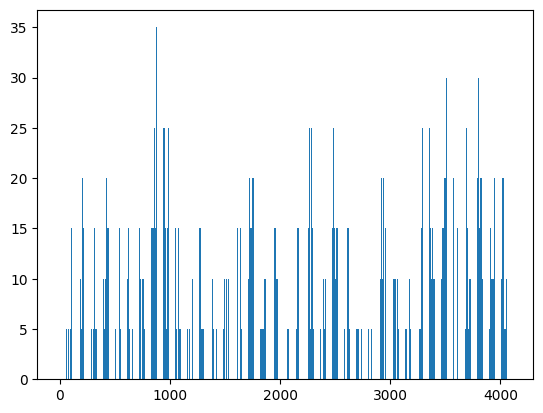

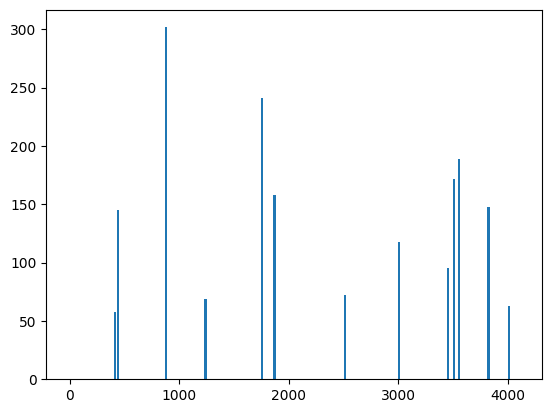

array([ 877, 1754, 3509, 3549], dtype=int64)

In [289]:
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=20)
omp.fit(Phi, y)
coefficients = [ i if i>0 else 0 for i in omp.coef_]

print(coefficients[877])
ma = np.argmax(coefficients)
print(ma)
print(sequence_list[ma])
print(coefficients[ma])

plt.bar([i for i in np.arange(len(sequence_list))],sequence_cost,width=0.5)
plt.show()
plt.bar([i for i in np.arange(len(coefficients))],coefficients,width=20)
plt.show()
np.intersect1d(np.argpartition(sequence_cost, -20)[-20:],np.nonzero(coefficients)[0])